In [1]:
using Distributed
procs_to_use = 10
if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end
;

In [2]:
@everywhere using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    StructArrays,
    StaticArrays,
    LoopVectorization,
    Parameters
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]


## Define molecular states for the laser cooling transition

In [5]:
# Define constants for the laser cooling transition
@consts begin
    λ = 626e-9             # wavelength of transition
    Γ = 2π * 6.4e6         # transition linewidth
    m = @with_unit 57 "u"  # mass of CaOH
    k = 2π / λ             # wavenumber of transition
end
;

In [13]:
@everywhere include("CaOH_X(000).jl")
@everywhere include("CaOH_A(000).jl")
;

In [14]:
@everywhere begin
    H = CombinedHamiltonian([X_state_ham, A_state_ham])
    evaluate!(H)
    QuantumStates.solve!(H)
    update_basis_tdms!(H)
    update_tdms!(H)
end

In [24]:
H.states[20]

State{HundsCaseB_LinearMolecule}(4.7862093554211906e14, HundsCaseB_LinearMolecule[HundsCaseB_LinearMolecule(0.0, "X", 0, 0, 0, 1/2, 1/2, 0, 0, 0, 1, 3/2, 2, -2, (K = 0, N = 0:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -2.0:1.0:2.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 0, 0, 1/2, 1/2, 0, 0, 0, 1, 1/2, 1, -1, (K = 0, N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 0, 0, 1/2, 1/2, 0, 0, 0, 1, 3/2, 1, -1, (K = 0, N = 0:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -1.0:1.0:1.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 0, 0, 1/2, 1/2, 0, 0, 0, 1, 3/2, 2, -1, (K = 0, N = 0:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -2.0:1.0:2.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 0, 0, 1/2, 1/2, 0, 0, 0, 1, 1/2, 0, 0, (K = 0, N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = 0.0:1.0:0.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 0, 0, 1/2, 1/2, 0, 0, 0, 1, 1/2, 1, 0, (K = 0, N = 0:∞, J = 0.5:1.0:1.5, F = 0.0:1.0:1.0, M = -1.0:1.0:1.0)), HundsCaseB_LinearMole

In [ ]:

# Add Zeeman terms
Zeeman_x(state, state′) = (Zeeman(state, state′,-1) - Zeeman(state, state′,1))/sqrt(2)
Zeeman_y(state, state′) = im*(Zeeman(state, state′,-1) + Zeeman(state, state′,1))/sqrt(2)
Zeeman_z(state, state′) = Zeeman(state, state′, 0)

In [7]:
# @everywhere begin
#     ground_state_idxs = 5:16
#     excited_state_idxs = [5:8; 9:16; 37:48]
    
#     n_g_states = length(ground_state_idxs)
#     n_e_states = length(excited_state_idxs)
#     n_states = n_g_states + n_e_states

#     ground_states = X_state_ham.states[ground_state_idxs]
#     excited_states = A_state_ham.states[excited_state_idxs]
#     states = [ground_states; excited_states]

#     d = zeros(ComplexF64, n_states, n_states, 3)
#     d_ge1 = zeros(ComplexF64, n_g_states, n_e_states, 3)
#     d_ge2 = zeros(ComplexF64, n_e_states, n_g_states, 3)
    
#     basis_tdms = get_tdms_two_bases(X_state_ham.basis, A_state_caseB_basis, TDM)
#     tdms_between_states!(d_ge1, basis_tdms, ground_states, excited_states)
#     d[1:n_g_states, (n_g_states+1):n_states, :] .= d_ge1
    
#     basis_tdms = get_tdms_two_bases(A_state_caseB_basis, X_state_ham.basis, TDM)
#     tdms_between_states!(d_ge2, basis_tdms, excited_states, ground_states)
#     d[(n_g_states+1):n_states, 1:n_g_states, :] .= d_ge2
    
#     Zeeman_x_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_x, ground_states, excited_states) .* (1e-4 * gS * μB * (2π/Γ) / h))
#     Zeeman_y_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_y, ground_states, excited_states) .* (1e-4 * gS * μB * (2π/Γ) / h))
#     Zeeman_z_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_z, ground_states, excited_states) .* (1e-4 * gS * μB * (2π/Γ) / h))

#     for state ∈ states
#         state.E *= 1e6
#     end
# end
# ;

## Define experimental parameters

In [8]:
@everywhere begin
    using MutableNamedTuples

    # Initial condition of the molecule cloud
    temp = @with_unit 30 "μK"
    diameter = @with_unit 0.1 "mm"
     
    # Define B field gradient and ramp time
    B_grad_start = 0.
    B_grad_end   = 75.
    # ramp_time = 10e-3 / (1/Γ)
    # ramp_time = 5e-3 / (1/Γ)
    ramp_time = 1e-10 / (1/Γ)
    
    ## 3 FREQ CONFIG ###
    Isat = π*h*c*Γ/(3λ^3)
    P = 0.3 * 13.1e-3 # 13.1 mW/1 V, factor of 0.25 to match scattering rates
    I = 2P / (π * 4e-3^2) # 8 mm 1/e^2 diameter beams
    s = I / Isat
    
    ## Laser detunings
    detuning = +7.6
    δ1 = +0.0
    δ2 = +0.0
    δ3 = -1.00
    δ4 = +0.75
    
    Δ1 = 1e6 * (detuning + δ1)
    Δ2 = 1e6 * (detuning + δ2)
    Δ3 = 1e6 * (detuning + δ3)
    Δ4 = 1e6 * (detuning + δ4)
    
    ## Laser intensities
    s1 = 3.7s / (3.7 + 2.8 + 3.5)
    s2 = 0.0
    s3 = 2.8s / (3.7 + 2.8 + 3.5)
    s4 = 3.5s / (3.7 + 2.8 + 3.5)
    
#     ## Laser detunings
#     detuning = +7.6
#     δ1 = +0.0
#     δ2 = +0.0
#     δ3 = -1.00
#     δ4 = -0.30
    
#     Δ1 = 1e6 * (detuning + δ1)
#     Δ2 = 1e6 * (detuning + δ2)
#     Δ3 = 1e6 * (detuning + δ3)
#     Δ4 = 1e6 * (detuning + δ4)
    
#     ## Laser intensities
#     s1 = 5s / (3.7 + 2.8 + 3.5)
#     s2 = 0.0
#     s3 = 5s / (3.7 + 2.8 + 3.5)
#     s4 = 5s / (3.7 + 2.8 + 3.5)

    # ## 3 FREQ CONFIG, BUT WALKING WAVE ON J=1/2 ###
    # ## Laser detunings
    # detuning = 7.6
    # δ1 = -1.00
    # δ2 = +0.75
    # δ3 = +0.00
    # δ4 = +4.00
    
    # Δ1 = 1e6 * (detuning + δ1)
    # Δ2 = 1e6 * (detuning + δ2)
    # Δ3 = 1e6 * (detuning + δ3)
    # Δ4 = 1e6 * (detuning + δ4)
    
    # ## Laser intensities
    # s1 = 6.0s / (3.7 + 2.8 + 3.5)
    # s2 = 6.0s / (3.7 + 2.8 + 3.5)
    # s3 = 0.0s
    # s4 = 5.0s / (3.7 + 2.8 + 3.5)

#     ## 3 FREQ CONFIG, BUT WALKING WAVE ON J=1/2 AND J=3/2 ###
#     ## Laser detunings
#     detuning = +7.6
#     δ1 = -1.00
#     δ2 = +0.75
#     δ3 = -1.00
#     δ4 = +0.75
    
#     Δ1 = 1e6 * (detuning + δ1)
#     Δ2 = 1e6 * (detuning + δ2)
#     Δ3 = 1e6 * (detuning + δ3)
#     Δ4 = 1e6 * (detuning + δ4)
    
#     ## Laser intensities
#     s1 = 2.0s / (3.7 + 2.8 + 3.5)
#     s2 = 2.0s / (3.7 + 2.8 + 3.5)
#     s3 = 3.0s / (3.7 + 2.8 + 3.5)
#     s4 = 3.0s / (3.7 + 2.8 + 3.5)
    
#     ## "Single-frequency" blue MOT
#     ## Laser detunings
#     detuning = +15.0
#     δ1 = -1.00
#     δ2 = -0.60
#     δ3 = -1.00
#     δ4 = +0.75
    
#     Δ1 = 1e6 * (detuning + δ1)
#     Δ2 = 1e6 * (detuning + δ2)
#     Δ3 = 1e6 * (detuning + δ3)
#     Δ4 = 1e6 * (detuning + δ4)
    
#     ## Laser intensities
#     s1 = 6.0s
#     s2 = 6.0s
#     s3 = 0.0s
#     s4 = 0.0s

#     ## "Single-frequency" blue MOT (alternative 1)
#     ## Laser detunings
#     detuning = +10.0
#     δ1 = -1.00
#     δ2 = -0.00
#     δ3 = -1.00
#     δ4 = +0.75
    
#     Δ1 = 1e6 * (detuning + δ1)
#     Δ2 = 1e6 * (detuning + δ2)
#     Δ3 = 1e6 * (detuning + δ3)
#     Δ4 = 1e6 * (detuning + δ4)
    
#     ## Laser intensities
#     s1 = 0.0s
#     s2 = 3.0s
#     s3 = 0.0s
#     s4 = 0.0s
    
#     ## "Single-frequency" blue MOT
#     ## Laser detunings
#     detuning = +50.0
#     δ1 = -1.00
#     δ2 = -0.00
#     δ3 = -1.00
#     δ4 = +0.75
    
#     Δ1 = 1e6 * (detuning + δ1)
#     Δ2 = 1e6 * (detuning + δ2)
#     Δ3 = 1e6 * (detuning + δ3)
#     Δ4 = 1e6 * (detuning + δ4)
    
#     ## Laser intensities
#     s1 = 0.0s
#     s2 = 9.0s
#     s3 = 0.0s
#     s4 = 0.0s
    
#     ## Optimizing the usual blue MOT config
#     ## Laser detunings
#     detuning = +7.6
#     δ1 = +0.00
#     δ2 = +0.00
#     δ3 = -1.00
#     δ4 = +0.75
    
#     Δ1 = 1e6 * (detuning + δ1)
#     Δ2 = 1e6 * (detuning + δ2)
#     Δ3 = 1e6 * (detuning + δ3)
#     Δ4 = 1e6 * (detuning + δ4)
    
#     ## Laser intensities
#     s1 = 0.5s
#     s2 = 0.0s
#     s3 = 0.5s
#     s4 = 0.5s

#     ## "Single-frequency"
#     ## Laser detunings
#     detuning = +80.0
#     δ1 = +0.00
#     δ2 = +0.00
#     δ3 = +0.00
#     δ4 = +0.00
    
#     Δ1 = 1e6 * (detuning + δ1)
#     Δ2 = 1e6 * (detuning + δ2)
#     Δ3 = 1e6 * (detuning + δ3)
#     Δ4 = 1e6 * (detuning + δ4)
    
#     ## Laser intensities
#     s1 = 4s
#     s2 = 0s
#     s3 = 0s
#     s4 = 0s
    
    sim_params = MutableNamedTuple( pol1_x=σ⁺, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻,
                                    s1=s1, s2=s2, s3=s3, s4=s4,
                                    Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4,
    
                                    B_grad_start = B_grad_start,
                                    B_grad_end = B_grad_end,
                                    B_offset = SVector(0., 0., 0.),
                                    B_ramp_time = ramp_time,
                                    Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,
    
                                    temp=temp, diameter=diameter,

                                    s_ramp_time = ramp_time,
                                    s_ramp_factor = 7/9,
                                    # s_ramp_factor = 3/4,
    
                                    pol_imbalance=0.0, 
                                    s_imbalance = (0., 0., 0.), retro_loss=0., 
                                    off_center=[0,0,0,0,0,0].*1e-3, 
                                    pointing_error =[0,0,0,0,0,0],
        
                                    ODT_intensity = 4*2*13 / (π * (8e-6)^2),
                                    ODT_size = (8e-6, 150e-6, 8e-6),
                                    ODT_position = [0., 0.],
                                    ODT_pol = [0,1,0]
        )
end

## Define lasers

In [9]:
@everywhere begin
    include("define_ODT_Hamiltonian.jl")   
    H_ODT = get_H_ODT(states, ground_states, excited_states, sim_params.ODT_intensity, sim_params.ODT_pol)
end
;

In [10]:
@everywhere begin
    d = d[1:16,1:16,:]
    states = states[1:16]
    H_ODT = H_ODT[1:16,1:16]
    Zeeman_x_mat = Zeeman_x_mat[1:16,1:16]
    Zeeman_y_mat = Zeeman_y_mat[1:16,1:16]
    Zeeman_z_mat = Zeeman_z_mat[1:16,1:16]
end
;

In [11]:
@everywhere begin
    include("define_lasers.jl")
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_factor,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )
end
;

In [12]:
@everywhere function update_H_and_∇H(H, p, r, t)

    # define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx
    Zeeman_Hy = p.extra_data.Zeeman_Hy

    # set ramp factor
    τ_bfield = p.sim_params.B_ramp_time
    scalar = t/τ_bfield
    scalar = min(scalar, 1.0)
    
    B_grad = scalar * (p.sim_params.B_grad_end - p.sim_params.B_grad_start) + p.sim_params.B_grad_start
    
    gradient_x = +scalar * B_grad * 1e2 / k / 2
    gradient_y = +scalar * B_grad * 1e2 / k / 2
    gradient_z = -scalar * B_grad * 1e2 / k
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end

    ∇H = SVector{3, Float64}(0,0,0)
    
#     H_ODT = p.extra_data.H_ODT
    
#     ODT_x = p.sim_params.ODT_position[1] / (1 / p.k)
#     ODT_y = 0.0
#     ODT_z = p.sim_params.ODT_position[2] / (1 / p.k)
    
#     ODT_size = p.sim_params.ODT_size ./ (1 / p.k)
    
#     x, y, z = r
#     r2 = x^2 + y^2 + z^2
    
#     w0 = ODT_size[1]
#     zR = π*w0^2 / λ
    
#     # define some factors
#     a = 1 + (z/zR)^2
#     wz = w0 * sqrt(a)
    
#     b = exp(-2r2/wz^2)
    
#     scalar_ODT = (w0/wz)^2 * b
    
#     @turbo for i in eachindex(H)
#         H.re[i] += H_ODT[i] * scalar_ODT
#     end
    
#     ∇H = SVector{3, Float64}(
#         -4x * b / (a * wz^2), 
#         -4y * b / (a * wz^2), 
#         (-4z * b / wz^2) * (1 / a - r2 / zR^2) - 2z * b / (a^2 * zR^2)
#         )
    
    return ∇H
end

In [13]:
@everywhere begin
    extra_data = MutableNamedTuple(
    Zeeman_Hx = Zeeman_x_mat,
    Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat,
    H_ODT = H_ODT
    )
end

## Simulate trajectory for single particle

In [232]:
@everywhere begin
    t_start = 0.0
    t_end   = 5e-3
    t_span  = (t_start, t_end) ./ (1/Γ)

    using Logging: global_logger
    using TerminalLoggers: TerminalLogger
    global_logger(TerminalLogger())

    # define particle and initial position
    particle = Particle()
    particle.r = [0., 0., 0.1e-3] ./ (1/k)

    ψ₀ = zeros(ComplexF64, length(states))
    ψ₀[1] = 1.0

    p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), 4; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p)

    cb = ContinuousCallback(condition_simple, stochastic_collapse!, nothing, save_positions=(false,false))
end
@time sol = DifferentialEquations.solve(prob; alg=DP5(), reltol=1e-3, callback=cb, saveat=10, maxiters=80000000, progress=true, progress_steps=100000)
;

      From worker 10:	┌ Warning: Replacing docs for OpticalBlochEquations.stochastic_collapse! ::
      From worker 10:	│ Tuple{Any} in module OpticalBlochEquations
      From worker 10:	└ @ Base.Docs docs\Docs.jl:243
      From worker 5:	┌ Warning: Replacing docs for OpticalBlochEquations.stochastic_collapse! ::
      From worker 5:	│ Tuple{Any} in module OpticalBlochEquations
      From worker 5:	└ @ Base.Docs docs\Docs.jl:243
      From worker 5:	┌ Warning: Replacing docs for OpticalBlochEquations.schrodinger_stochastic ::
      From worker 5:	│ NTuple{7, Any} in module OpticalBlochEquations
      From worker 5:	└ @ Base.Docs docs\Docs.jl:243
      From worker 6:	┌ Warning: Replacing docs for OpticalBlochEquations.stochastic_collapse! ::
      From worker 6:	│ Tuple{Any} in module OpticalBlochEquations
      From worker 6:	└ @ Base.Docs docs\Docs.jl:243
      From worker 9:	┌ Warning: Replacing docs for OpticalBlochEquations.stochastic_collapse! ::
      From worker 9:	│ Tuple{Any} 

ODE   0%|█                                              |  ETA: N/A

      From worker 7:	│ NTuple{7, Any} in module OpticalBlochEquations


ODE  18%|█████████                                      |  ETA: 0:00:19



      From worker 7:	└ @ Base.Docs docs\Docs.jl:243


ODE  35%|█████████████████                              |  ETA: 0:00:14
ODE  53%|██████████████████████████                     |  ETA: 0:00:10
ODE  71%|██████████████████████████████████             |  ETA: 0:00:06
ODE  89%|██████████████████████████████████████████     |  ETA: 0:00:03

 22.546938 seconds (345.94 M allocations: 20.636 GiB, 13.22% gc time, 1.33% compilation time: 100% of which was recompilation)



ODE 100%|███████████████████████████████████████████████| Time: 0:00:22


In [262]:
@everywhere begin
    t_start = 0.0
    t_end   = 5e-3
    t_span  = (t_start, t_end) ./ (1/Γ)

    using Logging: global_logger
    using TerminalLoggers: TerminalLogger
    global_logger(TerminalLogger())

    # define particle and initial position
    particle = Particle()
    particle.r = [0., 0., 0.1e-3] ./ (1/k)

    ψ₀ = zeros(ComplexF64, length(states))
    ψ₀[1] = 1.0

    p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), 4; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    prob = ODEProblem(ψ_stochastic_diffusion_fast!, p.ψ, t_span, p)

    cb = ContinuousCallback(condition_simple, stochastic_collapse!, nothing, save_positions=(false,false))
end
@time sol = DifferentialEquations.solve(prob; alg=DP5(), reltol=1e-3, callback=cb, saveat=10, maxiters=80000000, progress=true, progress_steps=100000)
;

ODE   0%|█                                              |  ETA: N/A
ODE  18%|█████████                                      |  ETA: 0:00:08
ODE  36%|█████████████████                              |  ETA: 0:00:06
ODE  53%|██████████████████████████                     |  ETA: 0:00:04
ODE  71%|██████████████████████████████████             |  ETA: 0:00:03
ODE  89%|██████████████████████████████████████████     |  ETA: 0:00:01
ODE 100%|███████████████████████████████████████████████| Time: 0:00:08


  9.422168 seconds (507.92 k allocations: 48.688 MiB, 0.26% gc time, 6.89% compilation time: 100% of which was recompilation)


In [263]:
x(u) = real(u[16+4+1]) * (1/k)
y(u) = real(u[16+4+2]) * (1/k)
z(u) = real(u[16+4+3]) * (1/k)
vx(u) = real(u[16+4+4]) * (Γ/k)
vy(u) = real(u[16+4+5]) * (Γ/k)
vz(u) = real(u[16+4+6]) * (Γ/k)
;

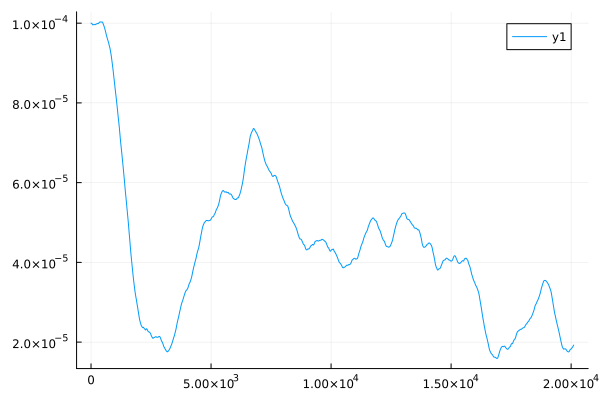

In [264]:
z.(sol.u) |> plot

In [265]:
using BenchmarkTools
ψ = deepcopy(p.ψ)
dψ = deepcopy(p.ψ)
@btime ψ_stochastic_potential!(ψ, dψ, p, 0.0)

  1.210 μs (0 allocations: 0 bytes)


In [329]:
using BenchmarkTools
ψ = deepcopy(p.ψ)
dψ = deepcopy(p.ψ)
@btime ψ_stochastic_diffusion_fast!($ψ, $dψ, $p, 0.0)

  1.190 μs (0 allocations: 0 bytes)


## Simulate multiple particles

In [441]:
@everywhere using Distributions, Plots

In [442]:
@everywhere begin
    const x_dist = Normal(0,60e-6)
    const y_dist = Normal(0,60e-6)
    const z_dist = Normal(0,60e-6)
end

uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end

@everywhere begin
    const Temp = 100e-6
    const v_dist = Normal(0,sqrt(kB*Temp/2m))
end

@everywhere function sample_position()
    r = (rand(x_dist), rand(y_dist), rand(z_dist))
end

@everywhere function sample_velocity()
    speed = rand(v_dist)
    v = sample_direction(speed)
end
;

In [443]:
@everywhere function prob_func(prob, i, repeat)
    
    t_start = 0.0
    t_end   = 10e-3
    t_span  = (t_start, t_end) ./ (1/Γ)
    
    extra_data = prob.p.extra_data
    sim_params = prob.p.sim_params

    # set initial particle parameters
    particle = Particle()
    r0 = sample_position()
    particle.r = r0 ./ (1/k)
    v0 = sample_velocity()
    particle.v = v0 ./ (Γ/k)

    ψ₀ = zeros(ComplexF64, length(states))
    ψ₀[1] = 1.0
    
    # define lasers
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_factor,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )

    d = prob.p.d
    n_excited = prob.p.n_excited

    # p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    # cb = ContinuousCallback(condition_simple, SE_collapse_pol_always!, nothing, save_positions=(false,false))
    # prob = ODEProblem(ψ_stochastic_diffusion_forcevariance!, p.ψ, t_span, p; callback=cb, reltol=1e-3, saveat=1000, maxiters=80000000)
    
    p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    cb = ContinuousCallback(condition_simple, stochastic_collapse!, nothing, save_positions=(false,false))
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p; callback=cb, reltol=1e-3, saveat=1000, maxiters=80000000)
    
    return prob
end
;

In [444]:
ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleDistributed(); trajectories=20)
;

136.783728 seconds (1.66 M allocations: 100.280 MiB, 0.03% gc time, 2.37% compilation time)


In [445]:
survived(x,y,z) = sqrt(x^2+y^2+z^2) <= 0.5e-3
;

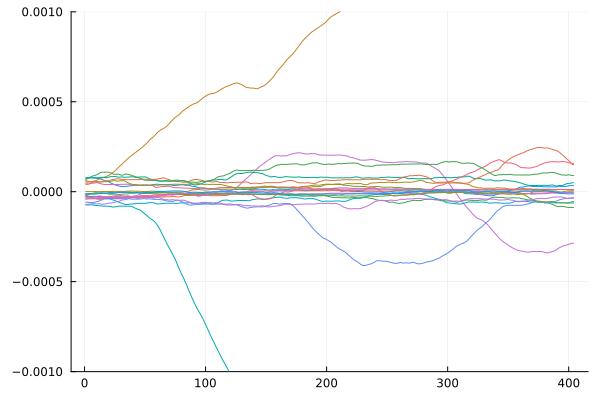

In [446]:
plot()
for sol ∈ ensemble_sol
    plot!(z.(sol.u))
end
plot!(
    legend=nothing,
    # xlim=(550,600),
    ylim=(-1e-3,1e-3)
    # ylim=(-0.02e-3,0.02e-3),
    # size=(1000,600)
)

In [447]:
mean(ensemble_sol[i].prob.p.n_scatters for i ∈ eachindex(ensemble_sol)) / 20e-3

126777.5

## Fitted size

In [418]:
using StatsBase

In [419]:
survived(x,y,z) = sqrt(x^2+y^2+z^2) <= 0.5e-3

function size(ensemble_sol, idx)
    xs = Float64[]
    ys = Float64[]
    zs = Float64[]
    for i ∈ eachindex(ensemble_sol)
        sol = ensemble_sol[i] 
        _x = x(sol.u[idx])
        _y = y(sol.u[idx])
        _z = z(sol.u[idx])
        if survived(_x,_y,_z)
            push!(xs, _x)
            push!(ys, _y)
            push!(zs, _z)
        end
    end
    return (std(xs) * std(ys) * std(zs))^(1/3)
end
;

In [420]:
using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2))
end

function cloud_size_fitted(xs)

    hist_data = fit(Histogram, xs, -1e-3:1e-5:1e-3)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    # histogram(hist_data)
    
    v_fit = curve_fit(Gaussian, v, fv, [60e-6, 0., 5000])
    σ, x0, A = v_fit.param
    
    # histogram!(xs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    return σ
end
;

In [421]:
xs = [x.(sol.u) for sol ∈ ensemble_sol]
ys = [y.(sol.u) for sol ∈ ensemble_sol]
zs = [z.(sol.u) for sol ∈ ensemble_sol]

survived_idxs = [survived(xs[i][end], ys[i][end], zs[i][end]) for i ∈ eachindex(xs)]

survived_xs = xs[survived_idxs]
survived_ys = ys[survived_idxs]
survived_zs = zs[survived_idxs]
;

3-element Vector{Float64}:
     1.90023767015121e-5
    -1.3761511755540237e-5
 15608.381456496605

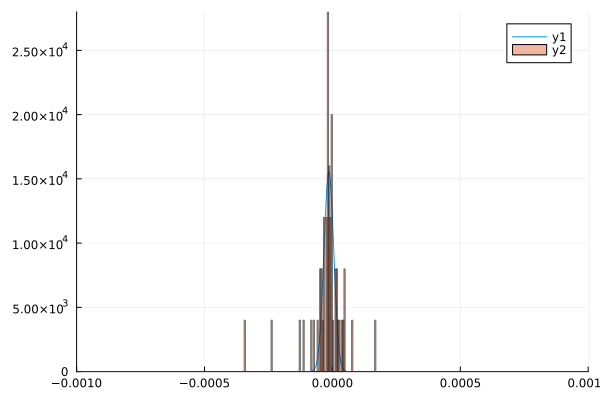

In [423]:
zs_end = [z[end] for z ∈ survived_zs]

hist_data = fit(Histogram, zs_end, -1e-3:0.5e-5:1e-3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [60e-6, 0., 5000])
σ, x0, A = v_fit.param

display(v_fit.param)
plot(v, Gaussian(v, v_fit.param))
histogram!(zs_end, bins=hist_data.edges, xlim=(-1e-3, +1e-3), alpha=0.5, normalize=true)

In [424]:
cloud_sizes_x_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_xs]) for i ∈ eachindex(survived_xs[1])]
cloud_sizes_y_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_ys]) for i ∈ eachindex(survived_ys[1])]
cloud_sizes_z_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_zs]) for i ∈ eachindex(survived_zs[1])]
cloud_sizes_fitted = (abs.(cloud_sizes_x_fitted) .* abs.(cloud_sizes_y_fitted) .* abs.(cloud_sizes_z_fitted)).^(1/3)
;

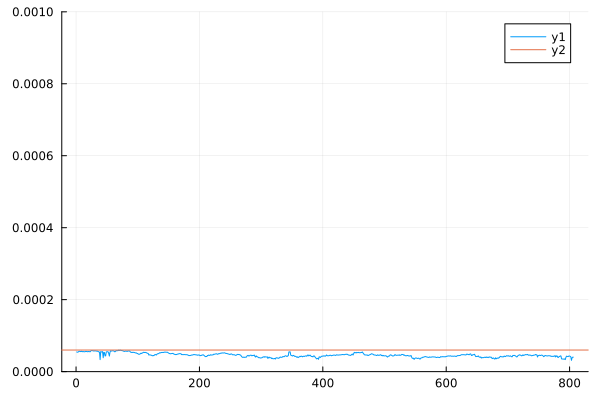

In [425]:
plot(cloud_sizes_fitted)
plot!(ylim=(0,1000e-6))
hline!([60e-6])

## Fitted temperature

In [640]:
using LsqFit

In [641]:
survived_sols = [sol for (i,sol) ∈ enumerate(ensemble_sol) if survived_idxs[i]]

i = length(ensemble_sol[1].t) - 6
vs = [sqrt(vx(sol.u[i])^2 + vy(sol.u[i])^2 + vz(sol.u[i])^2) for sol ∈ survived_sols]
m * mean(vs)^2 / 3kB |> display

function maxwell_boltzmann(v, p)
    A, temp = p
    return A * ((m/(2π*kB*temp))^(3/2) * 4π) .* v .^2 .* exp.(v .^2 .* (-m / (2*kB*temp)))
end

vs_tofit = vs#[vs .< 0.5]

hist_data = fit(Histogram, vs_tofit, 0.0:mean(vs_tofit)/5:mean(vs_tofit)*3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

histogram(hist_data)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [5, 100e-6])
A, temp = v_fit.param

display(v_fit.param)
plot(v, maxwell_boltzmann(v, v_fit.param))
histogram!(vs_tofit, bins=hist_data.edges, xlim=(0.0, mean(vs)*3), alpha=0.5, normalize=true)

9.053719684664154e-6

LoadError: DomainError with -4.355678277261524:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

## Calculate diffusion

In [272]:
@everywhere begin
    using ProgressMeter, StatsBase, Plots, Distributions
end

In [273]:
@everywhere begin
    const x_dist = Normal(0,60e-6)
    const y_dist = Normal(0,60e-6)
    const z_dist = Normal(0,60e-6)
end

uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end

@everywhere begin
    const Temp = 100e-6
    const v_dist = Normal(0,sqrt(kB*Temp/2m))
end

@everywhere function sample_position()
    r = (rand(x_dist), rand(y_dist), rand(z_dist))
end

@everywhere function sample_velocity()
    speed = rand(v_dist)
    v = sample_direction(speed)
end
;

In [274]:
@everywhere function compute_diffusion_averaged_real(prob, n_avgs, t_end, τ_total, n_times)
    
    # data arrays
    Cs = zeros(ComplexF64, n_times)
    fτ_fts = zeros(ComplexF64, n_times)

    χm  = zeros(ComplexF64, prob.p.n_states)
    χp  = zeros(ComplexF64, prob.p.n_states)
    χm′ = zeros(ComplexF64, prob.p.n_states)
    χm′ = zeros(ComplexF64, prob.p.n_states)
    
    ψ₀ = zeros(ComplexF64, prob.p.n_states)
    ψ₀[13] = 1.0
        
    ϕs = zeros(6)
    
    @showprogress for i ∈ 1:n_avgs
        
        # set times to simulate
        t_start = 0.0
        t_end′  = t_end + 1e-6 * rand()
        t_span  = (t_start, t_end′)

        τ_start = t_end′
        τ_end   = τ_start + τ_total
        τ_span  = (τ_start, τ_end)

        τ_times = range(τ_span[1], τ_span[2], n_times)

        # round all times
        t_span  = round.(t_span ./ (1/Γ), digits=9)
        τ_span  = round.(τ_span ./ (1/Γ), digits=9)
        τ_times = round.(τ_times ./ (1/Γ), digits=9)
        
        r0 = sample_position()
        v0 = sample_velocity()
        prob.p.r  = r0 ./ (1/k)
        prob.p.r0 = r0 ./ (1/k)
        prob.p.v  = v0 ./ (Γ/k)
        
        for i ∈ eachindex(ϕs)
            ϕs[i] = 2π*rand()
        end
        
        prob.p.fields.ϕ[1:6]   = ϕs
        prob.p.fields.ϕ[7:12]  = ϕs
        prob.p.fields.ϕ[13:18] = ϕs
        prob.p.fields.ϕ[19:24] = ϕs
        
        prob.u0 .= 0.0
        prob.u0[1:16] = ψ₀
        prob.p.time_to_decay = rand(prob.p.decay_dist) # reset the time to decay
        sol_ϕ = DifferentialEquations.solve(prob, tspan=t_span)
        ut = sol_ϕ.u[end]
        
        time_to_decay = sol_ϕ.prob.p.time_to_decay
        
        ϕ  = StructArray(ut[1:16])
        ft = ut[20+6+3]
        f  = sol_ϕ.prob.p.∇H_z
        Heisenberg!(f, sol_ϕ.prob.p.eiωt)
        
        χm  = ϕ .- f*ϕ
        χp  = ϕ .+ f*ϕ
        μm  = norm(χm)
        μp  = norm(χp)
        χm ./= μm
        χp ./= μp

        prob.u0 .= ut
        prob.p.time_to_decay = time_to_decay
        sol_ϕτ = DifferentialEquations.solve(prob, tspan=τ_span, saveat=τ_times)

        prob.u0 .= ut
        prob.u0[1:16] = χm
        prob.u0[26+3] = χm' * f * χm
        prob.p.time_to_decay = time_to_decay
        sol_χm = DifferentialEquations.solve(prob, tspan=τ_span, saveat=τ_times)

        prob.u0 .= ut
        prob.u0[1:16] = χp
        prob.u0[26+3] = χp' * f * χp
        prob.p.time_to_decay = time_to_decay
        sol_χp = DifferentialEquations.solve(prob, tspan=τ_span, saveat=τ_times)
        
        for j ∈ 1:n_times
            
            cm = real(sol_χm.u[j][26+3])
            cp = real(sol_χp.u[j][26+3])
    
            C = (1/4) * (μp^2 * cp - μm^2 * cm)
            Cs[j] += C
            
            fτ = sol_ϕτ.u[j][20+6+3]
            fτ_fts[j] += fτ * ft
        end
    end
    Cs ./= n_avgs
    fτ_fts ./= n_avgs
    
    return Cs, fτ_fts
end
;

In [303]:
@everywhere begin
    particle = Particle()
    ψ₀ = zeros(ComplexF64, length(states))
    ψ₀[13] = 1.0
    p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), 4; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    callback = ContinuousCallback(condition_simple, stochastic_collapse!, nothing, save_positions=(false,false))
    prob = ODEProblem(ψ_stochastic_diffusion_fast!, p.ψ, t_span, p; alg=DP5(), callback=callback, reltol=1e-5)
    
    n_avgs = 5000
    
    # define times for the diffusion coefficient
    t_end   = 1e-5
    τ_total = 1e-5
    n_times = 30000
    
    dτs = zeros(n_times)
    dτs .= (τ_total / n_times) / (1/Γ)
    # dτs = cumsum(dτ)
end
;

In [304]:
tasks = Vector{Future}(undef, procs_to_use)
for i ∈ 1:procs_to_use
    tasks[i] = @spawnat i compute_diffusion_averaged_real(prob, n_avgs, t_end, τ_total, n_times)
end
@time rets = fetch.(tasks)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:34:24
Excessive output truncated after 635139 bytes.

In [305]:
Cs = real.(ret[1] for ret ∈ rets)
fτ_fts = real.(ret[2] for ret ∈ rets)
;

In [306]:
C_integrated = cumsum.(Cs[i] .* dτs for i ∈ eachindex(Cs))
fτ_ft_integrated = cumsum.(fτ_fts[i] .* dτs for i ∈ eachindex(fτ_fts))
diffusion = (C_integrated .- fτ_ft_integrated)
;

In [307]:
Cs = real.(mean(ret[1] for ret ∈ rets))
fτ_fts = real.(mean(ret[2] for ret ∈ rets))
;

In [308]:
C_integrated = cumsum(Cs .* dτs)
fτ_ft_integrated = cumsum(fτ_fts .* dτs)
diffusion = (C_integrated .- fτ_ft_integrated)
;

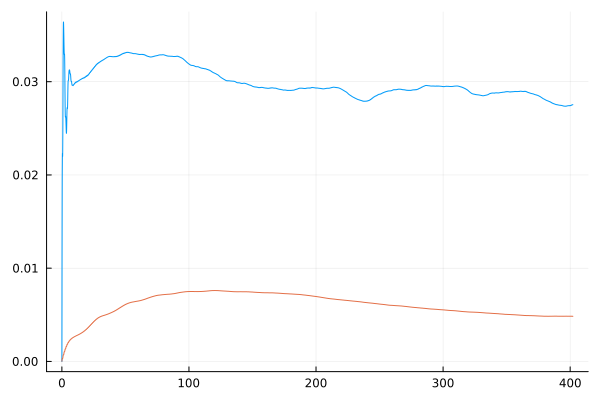

In [309]:
plot(cumsum(dτs), C_integrated)
plot!(cumsum(dτs), fτ_ft_integrated)
plot!(legend=nothing)

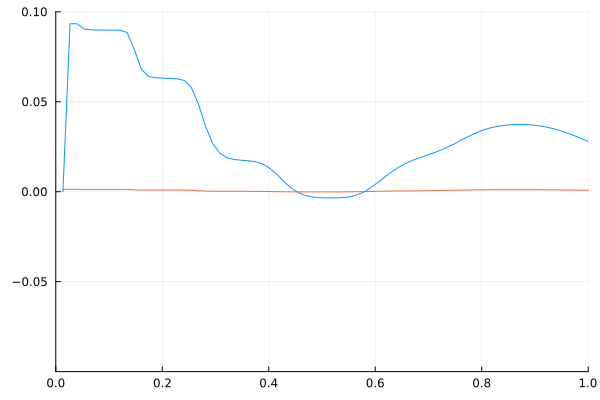

In [333]:
plot(cumsum(dτs), Cs)
plot!(cumsum(dτs), fτ_fts)
plot!(xlim=(0,1))
plot!(ylim=(-0.1, 0.1))
plot!(legend=nothing)

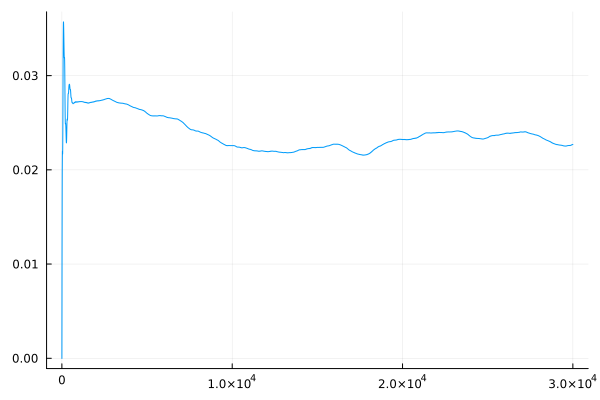

In [319]:
plot(diffusion, legend=nothing)

In [312]:
@everywhere diffusion_constant = mean($diffusion[end])

In [313]:
diffusion_constant

0.022692641218944112

In [73]:
# TODO: Add phase scrambling to averaging

## Constant diffusion simulation

In [136]:
@everywhere diffusion_constant = [0.007, 0.007, 0.007]
# @everywhere diffusion_constant = [0.005, 0.005, 0.005]
# @everywhere diffusion_constant = [0.0, 0.0, 0.0]
;

In [75]:
@everywhere begin
    t_start = 0.0
    t_end   = 5e-3
    t_span  = (t_start, t_end) ./ (1/Γ)

    ψ₀ = zeros(ComplexF64, length(states))
    ψ₀[1] = 1.0

    dt = 2e-9/(1/Γ)
    
    # set initial particle position
    r0 = [0., 0., 0.1e-3]
    particle.r = r0 ./ (1/k)
    
    p = schrodinger_stochastic_constant_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), 4, diffusion_constant; 
        sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H, dt=dt)
    
    cb = ContinuousCallback(condition_simple, SE_collapse_pol_constant_diffusion!, nothing, save_positions=(false,false))
    
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p; 
        callback=cb, reltol=5e-4, saveat=1000, maxiters=80000000)
    
    # prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p; 
    #     adaptive=false, dt=dt, callback=cb, reltol=5e-4, saveat=1000, maxiters=80000000)
    
end
    
@time sol = DifferentialEquations.solve(prob, alg=DP5(), progress=true, progress_steps=50000)
;

ODE   0%|█                                              |  ETA: N/A
ODE   4%|██                                             |  ETA: 0:00:17
ODE   8%|████                                           |  ETA: 0:00:16
ODE  12%|██████                                         |  ETA: 0:00:16
ODE  16%|████████                                       |  ETA: 0:00:15
ODE  20%|██████████                                     |  ETA: 0:00:14
ODE  24%|████████████                                   |  ETA: 0:00:13
ODE  29%|██████████████                                 |  ETA: 0:00:12
ODE  33%|████████████████                               |  ETA: 0:00:12
ODE  37%|██████████████████                             |  ETA: 0:00:11
ODE  41%|████████████████████                           |  ETA: 0:00:10
ODE  45%|██████████████████████                         |  ETA: 0:00:09
ODE  49%|████████████████████████                       |  ETA: 0:00:09
ODE  53%|██████████████████████████                     |  ETA: 0:00

 21.498265 seconds (4.89 M allocations: 324.842 MiB, 0.31% gc time, 17.38% compilation time)


ODE 100%|███████████████████████████████████████████████| Time: 0:00:17


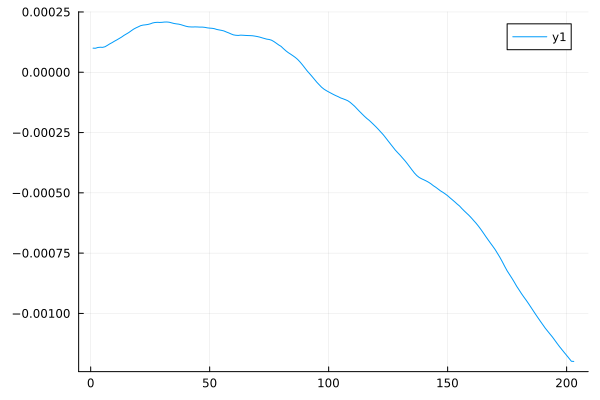

In [85]:
z.(sol.u) |> plot

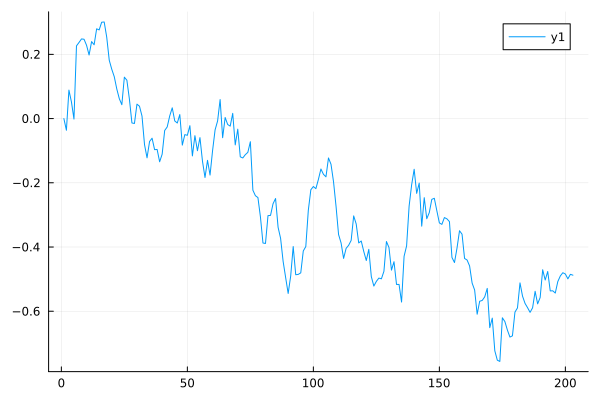

In [86]:
vz.(sol.u) |> plot

In [87]:
sqrt(mean((vz.(sol.u) .- mean(vz.(sol.u))).^2))

0.25479870575951846

In [88]:
prob.p.n_scatters / 5e-3

359600.0

## Solve multiple trajectories with constant diffusion

In [103]:
@everywhere begin
    const x_dist = Normal(0,60e-6)
    const y_dist = Normal(0,60e-6)
    const z_dist = Normal(0,60e-6)
end

@everywhere begin
    const Temp = 100e-6
    const vx_dist = Normal(0,sqrt(kB*Temp/(2m)))
    const vy_dist = Normal(0,sqrt(kB*Temp/(2m)))
    const vz_dist = Normal(0,sqrt(kB*Temp/(2m)))
end

@everywhere function sample_position()
    r = (rand(x_dist), rand(y_dist), rand(z_dist))
end

@everywhere function sample_velocity()
    v = (rand(vx_dist), rand(vy_dist), rand(vz_dist))
end
;

In [104]:
@everywhere function prob_func(prob, i, repeat)
    
    p = prob.p
    
    t_start = 0.0
    t_end   = 10e-3
    t_span  = (t_start, t_end) ./ (1/Γ)
    
    extra_data = p.extra_data
    sim_params = p.sim_params

    # set initial particle parameters
    particle = Particle()
    r0 = sample_position()
    particle.r = r0 ./ (1/k)
    v0 = sample_velocity()
    particle.v = v0 ./ (Γ/k)

    ψ₀ = zeros(ComplexF64, length(states))
    ψ₀[1] = 1.0
    
    # define lasers
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_factor,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )

    d = p.d
    n_excited = 4
    
    p = schrodinger_stochastic_constant_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), 4, diffusion_constant; 
        sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H, dt=dt)
    cb = ContinuousCallback(condition_simple, SE_collapse_pol_constant_diffusion!, nothing, save_positions=(false,false))
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p; 
        callback=cb, reltol=5e-4, saveat=1000, maxiters=80000000)
    
    # p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), 4; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    # cb = ContinuousCallback(condition_simple, SE_collapse_pol_always!, nothing, save_positions=(false,false))
    # prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p; callback=cb, reltol=5e-4, saveat=1000, maxiters=80000000)
    
    # prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p; 
    #     adaptive=false, dt=dt, callback=cb, reltol=5e-4, saveat=1000, maxiters=80000000)
    
    return prob
end;

In [105]:
ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleDistributed(); trajectories=20)
;

114.060796 seconds (567.33 k allocations: 24.679 MiB)


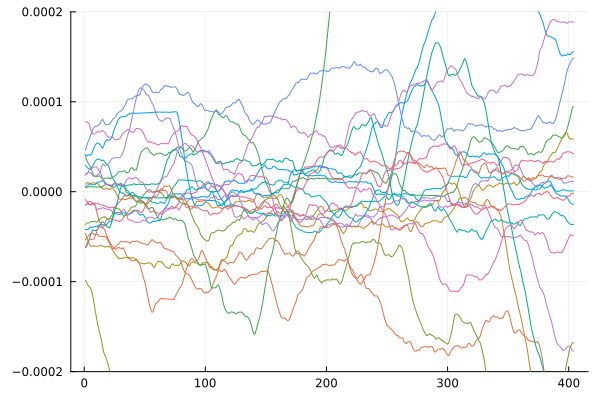

In [110]:
plot()
for sol ∈ ensemble_sol
    plot!(z.(sol.u))
end
plot!(
    legend=nothing,
    # xlim=(550,600),
    ylim=(-0.2e-3,0.2e-3)
    # ylim=(-0.02e-3,0.02e-3),
    # size=(1000,600)
)

## Fitted size

In [111]:
using StatsBase

In [112]:
survived(x,y,z) = sqrt(x^2+y^2+z^2) <= 0.1

function size(ensemble_sol, idx)
    xs = Float64[]
    ys = Float64[]
    zs = Float64[]
    for i ∈ eachindex(ensemble_sol)
        sol = ensemble_sol[i] 
        _x = x(sol.u[idx])
        _y = y(sol.u[idx])
        _z = z(sol.u[idx])
        if survived(_x,_y,_z)
            push!(xs, _x)
            push!(ys, _y)
            push!(zs, _z)
        end
    end
    return (std(xs) * std(ys) * std(zs))^(1/3)
end
;

In [113]:
using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2))
end

function cloud_size_fitted(xs)

    hist_data = fit(Histogram, xs, -1e-3:1e-5:1e-3)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    # histogram(hist_data)
    
    v_fit = curve_fit(Gaussian, v, fv, [60e-6, 0., 5000])
    σ, x0, A = v_fit.param
    
    # histogram!(xs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    return σ
end
;

In [114]:
xs = [x.(sol.u) for sol ∈ ensemble_sol]
ys = [y.(sol.u) for sol ∈ ensemble_sol]
zs = [z.(sol.u) for sol ∈ ensemble_sol]

survived_idxs = [survived(xs[i][end], ys[i][end], zs[i][end]) for i ∈ eachindex(xs)]

survived_xs = xs[survived_idxs]
survived_ys = ys[survived_idxs]
survived_zs = zs[survived_idxs]
;

3-element Vector{Float64}:
    3.9921893144333224e-5
    4.912542789299448e-6
 5202.88974782822

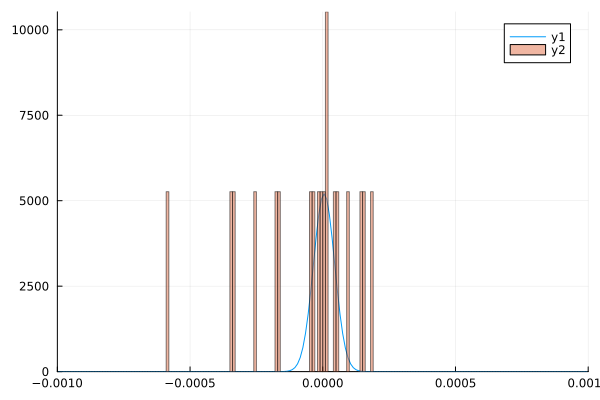

In [115]:
zs_end = [z[end] for z ∈ survived_zs]

hist_data = fit(Histogram, zs_end, -1e-3:1e-5:1e-3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [60e-6, 0., 5000])
σ, x0, A = v_fit.param

display(v_fit.param)
plot(v, Gaussian(v, v_fit.param))
histogram!(zs_end, bins=hist_data.edges, xlim=(-1e-3, +1e-3), alpha=0.5, normalize=true)

In [116]:
cloud_sizes_x_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_xs]) for i ∈ eachindex(survived_xs[1])]
cloud_sizes_y_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_ys]) for i ∈ eachindex(survived_ys[1])]
cloud_sizes_z_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_zs]) for i ∈ eachindex(survived_zs[1])]
cloud_sizes_fitted = (abs.(cloud_sizes_x_fitted) .* abs.(cloud_sizes_y_fitted) .* abs.(cloud_sizes_z_fitted)).^(1/3)
;

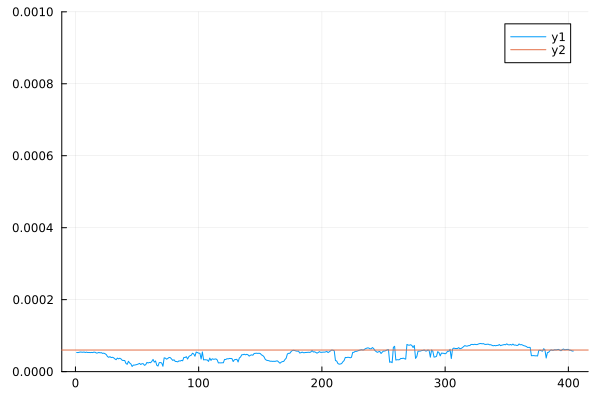

In [117]:
plot(cloud_sizes_fitted)
plot!(ylim=(0,1000e-6))
hline!([60e-6])

## Fitted temperature

In [1629]:
using LsqFit

0.0007819620310700105

2-element Vector{Float64}:
 0.9344302792414654
 0.00018975833133573993

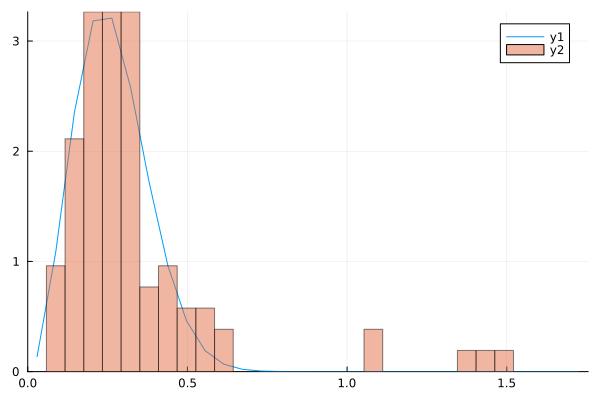

In [1630]:
survived_sols = [sol for (i,sol) ∈ enumerate(ensemble_sol) if survived_idxs[i]]

i = length(ensemble_sol[1].t)
vs = [sqrt(vx(sol.u[i])^2 + vy(sol.u[i])^2 + vz(sol.u[i])^2) for sol ∈ survived_sols]
m * mean(vs)^2 / 3kB |> display

function maxwell_boltzmann(v, p)
    A, temp = p
    return A * ((m/(2π*kB*temp))^(3/2) * 4π) .* v .^2 .* exp.(v .^2 .* (-m / (2*kB*temp)))
end

vs_tofit = vs#[vs .< 0.5]

hist_data = fit(Histogram, vs_tofit, 0.0:mean(vs_tofit)/10:mean(vs_tofit)*3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

histogram(hist_data)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [5, 100e-6])
A, temp = v_fit.param

display(v_fit.param)
plot(v, maxwell_boltzmann(v, v_fit.param))
histogram!(vs_tofit, bins=hist_data.edges, xlim=(0.0, mean(vs)*3), alpha=0.5, normalize=true)

## Solve OBEs

In [79]:
# Set initial conditions
particle = Particle()

ρ0 = zeros(ComplexF64, length(states), length(states)) # Use a static array for this??? Might be better...
ρ0[13,13] = 1.0
    
freq_res = 1e-1
p = obe(ρ0, particle, states, lasers, d, true, true; 
    sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, freq_res=freq_res, update_H_and_∇H=update_H_and_∇H)

p.r0 = (0., 0., 0.) .* 2π
p.v = (0., 0., 0.) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)
;

In [80]:
# using BenchmarkTools
# dρ = deepcopy(p.ρ0_vec)
# @btime ρ_updated!($dρ, $p.ρ0_vec, $p, 0.0)

In [81]:
t_end = 5p.period+1
tspan = (0., t_end)
prob = ODEProblem(ρ_updated!, p.ρ0_vec, tspan, p)
times = range(0, t_end, 1000)
;

In [82]:
prob.p.force_last_period = (0, 0, 0)
cb = PeriodicCallback(reset_force!, p.period)
@time sol = DifferentialEquations.solve(prob, DP5(), callback=cb, reltol=1e-3, saveat=times)
;

  4.361542 seconds (5.70 M allocations: 374.568 MiB, 4.83% gc time, 99.11% compilation time)


In [83]:
using Plots
plot_us = sol.u#[1:100:end]
plot_ts = sol.t#[1:100:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
# plot!(plot_ts, [real(u[end]) for u in plot_us])
# plot!(plot_ts, [real(u[end-1]) for u in plot_us])
# plot!(plot_ts, [real(u[end-2]) for u in plot_us])
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

LoadError: type Complex has no field u

In [84]:
prob.p.force_last_period * (1e-3 * ħ * k * Γ / m)

3-element SVector{3, Float64} with indices SOneTo(3):
 -4.05115085401415
 -3.1264852696191565
 -1.458878722971206

In [142]:
using LoopVectorization
"""
    dU = 1 - iHdt
"""
function evolve_U!(dU, U, p, t)

    @unpack H, H₀, E, E_k, dρ_soa, ρ_soa, tmp, Js, eiωt, ω, fields, ds, ds_state1, ds_state2, Γ, r, r0, v, Js = p
    
    r .= r0 .+ v * t
    
    update_H_obes!(p, t, r, H₀, fields, H, E_k, ds, ds_state1, ds_state2, Js)
    
    @turbo for i ∈ eachindex(dU)
        dU.re[i] = +H.im[i]
        dU.im[i] = -H.re[i]
    end
    for i ∈ 1:16
        dU[i,i] += 1.0
    end
    return nothing
end
;

In [144]:
# Set initial conditions
freq_res = 1e-1
t_end = p.period
tspan = (0., t_end)

particle = Particle()

p = obe(ρ0, particle, states, lasers, d, true, true; 
    sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, freq_res=freq_res, update_H_and_∇H=update_H_and_∇H)

p.r0 = (0., 0., 0.) .* 2π
p.v = (0., 0., 0.) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)

U0 = StructArray(diagm(ones(ComplexF64, n_states)))

prob = ODEProblem(evolve_U!, U0, tspan, p)
times = range(0, t_end, 1000)

@time sol = DifferentialEquations.solve(prob, DP5(), reltol=1e-4, saveat=times)
;

 10.517107 seconds (2.92 M allocations: 44.416 MiB, 0.09% gc time)


In [164]:
sol.u[2]

16×16 StructArray(::Matrix{Float64}, ::Matrix{Float64}) with eltype ComplexF64:
     1.06289+0.0im          …    4.79751e-5+2.78301e-5im
         0.0+0.0im             -0.000590277-0.000493857im
         0.0+0.0im              0.000415482+0.000241018im
         0.0+0.0im             -0.000131759-0.000179772im
         0.0+0.0im             -0.000311016-0.000180418im
         0.0+0.0im          …   0.000117259+0.000159989im
         0.0+0.0im              0.000375824+0.000314434im
         0.0+0.0im               3.73822e-5+3.12759e-5im
         0.0+0.0im                      0.0+0.0im
         0.0+0.0im              -3.39235e-5-1.96788e-5im
         0.0+0.0im          …    1.05455e-5+1.43884e-5im
         0.0+0.0im                      0.0+0.0im
 0.000423758-0.000245819im              0.0+0.0im
 -0.00015308+0.000208863im              0.0+0.0im
 0.000542645-0.000454005im              0.0+0.0im
 -4.79751e-5+2.78301e-5im   …       1.03145+0.0im